# Final machine learning pipeline

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

from sklearn.linear_model import Lasso
from sklearn.metrics import (
    mean_squared_error, root_mean_squared_error, r2_score
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import (
    AddMissingIndicator, 
    MeanMedianImputer,
    CategoricalImputer
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import additional_preprocessors as ap

### Load dataset

In [3]:
data = pd.read_csv('../data/train.csv')
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Split into train and test (ie. val) sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0
)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

### Transform target

In [5]:
y_train = np.log(y_train)
y_test = np.log(y_test)

### Config

In [6]:
CATEGORICAL_VARS_WITH_NA_FREQUENT = [
    'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'GarageFinish'
]

CATEGORICAL_VARS_WITH_NA_MISSING = ['FireplaceQu']

NUMERICAL_VARS_WITH_NA = ['LotFrontage']

TEMPORAL_VARS = ['YearRemodAdd']
REF_VAR = 'YrSold'

DROP_FEATURES = ['YrSold']

NUMERICAL_LOG_VARS = ['LotFrontage', '1stFlrSF', 'GrLivArea']

BINARIZE_VARS = ['ScreenPorch']

QUAL_VARS = [
    'ExterQual', 'BsmtQual', 
    'HeatingQC', 'KitchenQual', 'FireplaceQu'
]

EXPOSURE_VARS = ['BsmtExposure']

FINISH_VARS = ['BsmtFinType1']

GARAGE_VARS = ['GarageFinish']

CATEGORICAL_VARS = ['MSSubClass',  'MSZoning',  'LotShape',  'LandContour',
                    'LotConfig', 'Neighborhood', 'RoofStyle', 'Exterior1st',
                    'Foundation', 'CentralAir', 'Functional', 'PavedDrive',
                    'SaleCondition']

QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,
                   'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

FEATURES = [
    'MSSubClass',
    'MSZoning',
    'LotFrontage',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'OverallQual',
    'OverallCond',
    'YearRemodAdd',
    'RoofStyle',
    'Exterior1st',
    'ExterQual',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'CentralAir',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'BsmtFullBath',
    'HalfBath',
    'KitchenQual',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'FireplaceQu',
    'GarageFinish',
    'GarageCars',
    'GarageArea',
    'PavedDrive',
    'WoodDeckSF',
    'ScreenPorch',
    'SaleCondition',
]

FEATURES = FEATURES + [REF_VAR]

### Restrict datasets to selected features

In [7]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((1314, 37), (146, 37))

### Pipeline

In [8]:
sale_price_pipeline = Pipeline([
    # imputation - categorical variables
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),
    
    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),

    # imputation - numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    ('numerical_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)),

    # temporal variables
    ('elapsed_time', ap.TemporalVariableTransformer(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)),
    
    ('drop_features', DropFeatures(features_to_drop=[REF_VAR])),
    
    # transform numerical variables
    ('log', LogTransformer(variables=NUMERICAL_LOG_VARS)),

    ('binarize', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)),

    # mappers
    ('mapper_qual', ap.Mapper(
        variables=QUAL_VARS, mappings=QUAL_MAPPINGS)),

    ('mapper_exposure', ap.Mapper(
        variables=EXPOSURE_VARS, mappings=EXPOSURE_MAPPINGS)),

    ('mapper_finish', ap.Mapper(
        variables=FINISH_VARS, mappings=FINISH_MAPPINGS)),

    ('mapper_garage', ap.Mapper(
        variables=GARAGE_VARS, mappings=GARAGE_MAPPINGS)),

    # categorical encoding
    ('to_object', ap.ToObjectTransformer(variables=CATEGORICAL_VARS)),
   
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS)),

    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),

    # feature scaling
    ('scaler', MinMaxScaler()),

    # model
    ('lasso', Lasso(alpha=0.001, random_state=0))
])

In [10]:
sale_price_pipeline.named_steps

{'missing_imputation': CategoricalImputer(variables=['FireplaceQu']),
 'frequent_imputation': CategoricalImputer(imputation_method='frequent',
                    variables=['BsmtQual', 'BsmtExposure', 'BsmtFinType1',
                               'GarageFinish']),
 'missing_indicator': AddMissingIndicator(variables=['LotFrontage']),
 'numerical_imputation': MeanMedianImputer(imputation_method='mean', variables=['LotFrontage']),
 'elapsed_time': TemporalVariableTransformer(reference_variable='YrSold',
                             variables=['YearRemodAdd']),
 'drop_features': DropFeatures(features_to_drop=['YrSold']),
 'log': LogTransformer(variables=['LotFrontage', '1stFlrSF', 'GrLivArea']),
 'binarize': SklearnTransformerWrapper(transformer=Binarizer(threshold=0),
                           variables=['ScreenPorch']),
 'mapper_qual': Mapper(mappings={'Ex': 5, 'Fa': 2, 'Gd': 4, 'Missing': 0, 'NA': 0, 'Po': 1,
                  'TA': 3},
        variables=['ExterQual', 'BsmtQual', 'He

### Train pipeline

In [9]:
sale_price_pipeline.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['FireplaceQu'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtQual', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'GarageFinish'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['LotFrontage'])),
                ('numerical_imputation',
                 MeanMedianImputer(imputation_me...
                                             'Foundation', 'CentralAir',
                                             'Functional', 'PavedDrive',
                                             'SaleCondition'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['MSSubClass', 'MSZoning', 'LotShape',
                                           'LandContour', 'LotConfig',
                                           'Neighborhood', 'RoofStyle',
                                           'Exterior1st', 'Foundation',
                                           'CentralAir', 'Functional',
                                           'PavedDrive', 'SaleCondition'])),
                ('scaler', MinMaxScaler()),
                ('lasso', Lasso(alpha=0.001, random_state=0))])

### Evaluate model

Train set

In [11]:
pred = sale_price_pipeline.predict(X_train)

print('train mse: {}'.format(
    mean_squared_error(np.exp(y_train), np.exp(pred))))
print('train rmse: {}'.format(
    root_mean_squared_error(np.exp(y_train), np.exp(pred))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))

train mse: 781396630.9031372
train rmse: 27953.472609018314
train r2: 0.8748530315439074


Val set (labelled test set here)

In [12]:
pred = sale_price_pipeline.predict(X_test)

print('test mse: {}'.format(
    mean_squared_error(np.exp(y_test), np.exp(pred))))
print('test rmse: {}'.format(
    root_mean_squared_error(np.exp(y_test), np.exp(pred))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))

test mse: 1060769014.9333141
test rmse: 32569.44910392735
test r2: 0.845641557120844


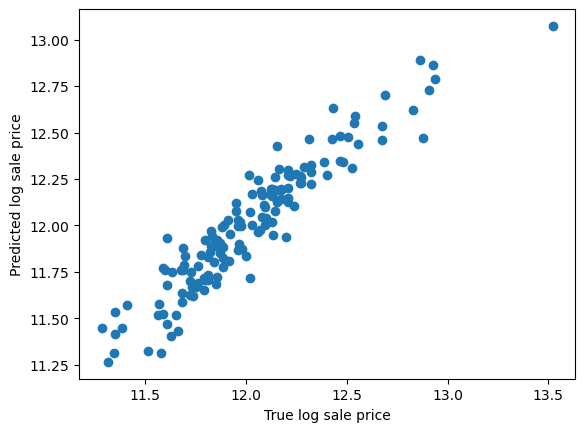

In [14]:
plt.scatter(y_test, sale_price_pipeline.predict(X_test))
plt.xlabel('True log sale price')
plt.ylabel('Predicted log sale price');

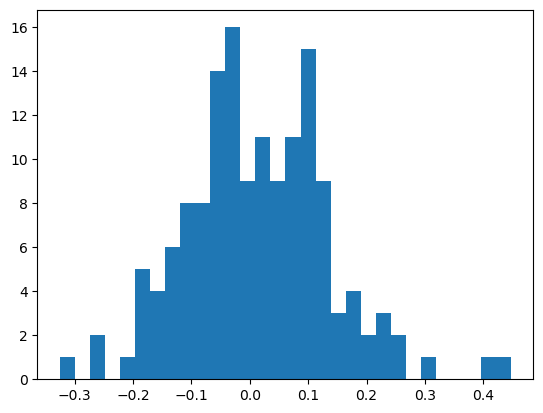

In [15]:
resids = y_test - sale_price_pipeline.predict(X_test)
plt.hist(resids, bins=30);

### Save the pipeline

In [16]:
joblib.dump(sale_price_pipeline, 'sale_price_pipeline.joblib')

['sale_price_pipeline.joblib']

### Score on new data

In [17]:
data = pd.read_csv('../data/test.csv')
data = data.drop('Id', axis=1)
data = data[FEATURES]
data.shape

(1459, 37)

Drop observations with NA

In [18]:
new_vars_with_na = [
    var for var in FEATURES 
    if var not in (CATEGORICAL_VARS_WITH_NA_FREQUENT +
    CATEGORICAL_VARS_WITH_NA_MISSING + 
    NUMERICAL_VARS_WITH_NA)
    and data[var].isnull().sum() > 0
]

new_vars_with_na

['MSZoning',
 'Exterior1st',
 'BsmtFullBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea']

In [19]:
data[new_vars_with_na].isnull().mean().sort_values(ascending=False)

MSZoning        0.002742
BsmtFullBath    0.001371
Functional      0.001371
Exterior1st     0.000685
KitchenQual     0.000685
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

In [20]:
data.dropna(subset=new_vars_with_na, inplace=True)

data.shape

(1449, 37)

In [21]:
new_preds = sale_price_pipeline.predict(data)

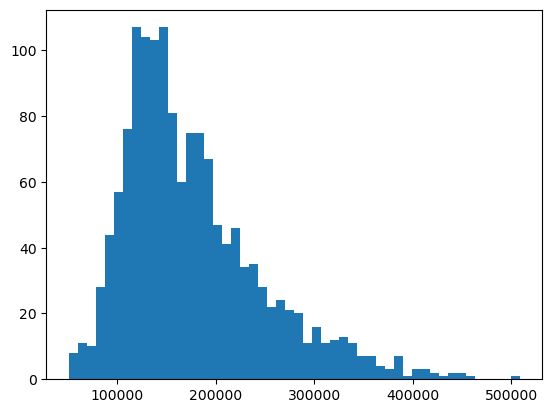

In [26]:
plt.hist(np.exp(new_preds), bins=50); 